In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lifelines.utils import concordance_index
from metric import score

In [5]:
train_path = "data/train.csv"
test_path = "data/test.csv"
sample_path = "data/sample_submission.csv"
data_dict_path = "data/data_dictionary.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
data_dict_df = pd.read_csv(data_dict_path)

In [6]:
from sdv.single_table import CTGANSynthesizer, CopulaGANSynthesizer
from sdv.metadata import SingleTableMetadata

In [19]:
# Configure and train the CTGAN model
ctgan = CTGANSynthesizer(
    metadata=metadata,
    embedding_dim=256,
    generator_dim=[512, 512],
    discriminator_dim=[512, 512],
    generator_lr=1e-4,
    discriminator_lr=1e-4,
    batch_size=1000,
    epochs=40,
    verbose=True,
    cuda=True,
)

efs_1_df = train[train["efs"] == 1]
ctgan.fit(efs_1_df)

C:\Users\tkvkh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sdv\single_table\base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
Gen. (-0.26) | Discrim. (-1.53): 100%|█████████████████████████████████████████████████| 40/40 [01:55<00:00,  2.89s/it]


In [20]:
sample_data = ctgan.sample(10000)

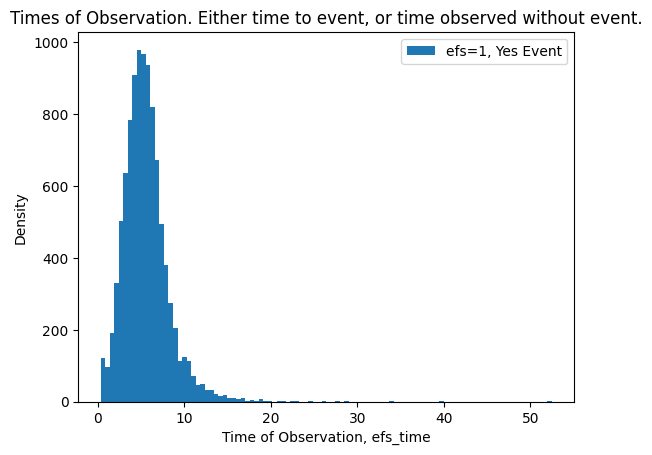

In [21]:
plt.hist(sample_data.loc[sample_data.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
# plt.hist(sample_data.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

In [22]:
ctgan = CTGANSynthesizer(
    metadata=metadata,
    embedding_dim=256,
    generator_dim=[512, 512],
    discriminator_dim=[512, 512],
    generator_lr=1e-4,
    discriminator_lr=1e-4,
    batch_size=1000,
    epochs=40,
    verbose=True,
    cuda=True,
)

efs_0_df = train[train["efs"] == 0]
ctgan.fit(efs_0_df)

C:\Users\tkvkh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sdv\single_table\base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
Gen. (-0.06) | Discrim. (-0.92): 100%|█████████████████████████████████████████████████| 40/40 [01:44<00:00,  2.62s/it]


In [23]:
sample_data_2 = ctgan.sample(10000)

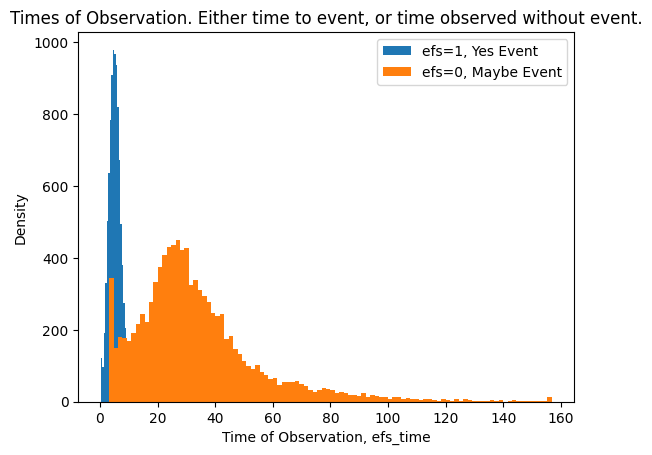

In [24]:
plt.hist(sample_data.loc[sample_data.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(sample_data_2.loc[sample_data_2.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

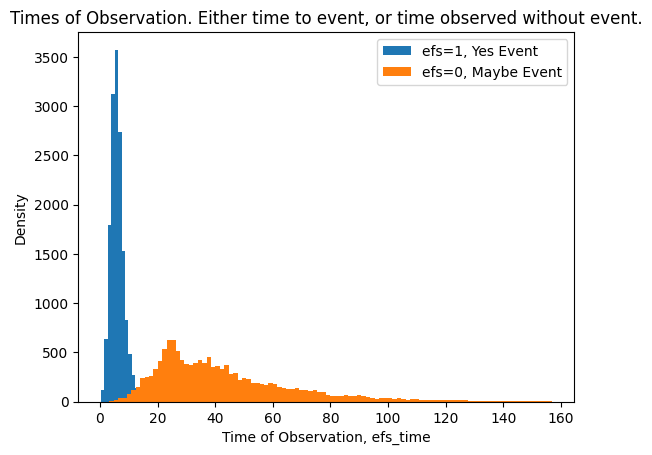

In [25]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

In [26]:
concat_train = pd.concat([train, sample_data, sample_data_2])
concat_train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [27]:
shuffled_df = concat_train.sample(frac=1).reset_index(drop=True)

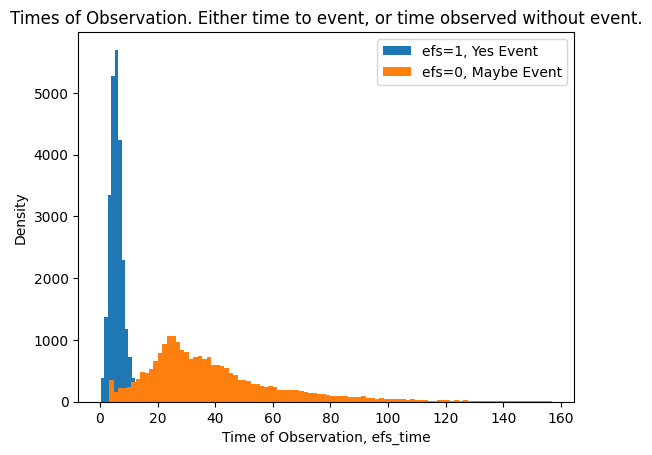

In [28]:
plt.hist(shuffled_df.loc[shuffled_df.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(shuffled_df.loc[shuffled_df.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

In [30]:
from lifelines import KaplanMeierFitter
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y
shuffled_df["y"] = transform_survival_probability(shuffled_df, time_col='efs_time', event_col='efs')

In [31]:
RMV = ["ID", "efs", "efs_time", "y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"Total features: {len(FEATURES)} - {FEATURES}")

Total features: 57 - ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [33]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        shuffled_df[c] = shuffled_df[c].fillna("NAN")
        # test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [34]:
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        shuffled_df[c],_ = shuffled_df[c].factorize()
        shuffled_df[c] -= shuffled_df[c].min()
        shuffled_df[c] = shuffled_df[c].astype("int32")
        shuffled_df[c] = shuffled_df[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if shuffled_df[c].dtype=="float64":
            shuffled_df[c] = shuffled_df[c].astype("float32")
        if shuffled_df[c].dtype=="int64":
            shuffled_df[c] = shuffled_df[c].astype("int32")

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [40]:
shuffled_df.head()
shuffled_df["ID"] = shuffled_df["index"]
shuffled_df = shuffled_df.drop(columns=["index"])

shuffled_df.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y
0,0,0,0,0,0,2.0,4.0,0,0,3.0,...,0,0,8.0,0,2.0,0,10.0,1.0,5.190,0.779383
1,1,1,1,1,0,1.0,4.0,1,0,3.0,...,0,0,4.0,0,1.0,0,5.0,1.0,5.707,0.726287
2,2,0,0,2,0,1.0,4.0,0,0,3.0,...,0,0,4.0,1,1.0,0,5.0,1.0,7.065,0.607380
3,3,2,0,3,0,2.0,8.0,2,0,6.0,...,1,0,8.0,0,2.0,0,10.0,1.0,8.015,0.556369
4,4,1,0,1,0,2.0,8.0,2,0,6.0,...,1,0,8.0,0,2.0,0,10.0,0.0,52.301,0.468866


In [41]:
shuffled_df = shuffled_df.reset_index()

FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(shuffled_df))

for i, (train_index, test_index) in enumerate(kf.split(shuffled_df)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = shuffled_df.loc[train_index,FEATURES].copy()
    y_train = shuffled_df.loc[train_index,"y"]    
    x_valid = shuffled_df.loc[test_index,FEATURES].copy()
    y_valid = shuffled_df.loc[test_index,"y"]
    # x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    # pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
# pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17442
[500]	validation_0-rmse:0.15772
[1000]	validation_0-rmse:0.15545
[1500]	validation_0-rmse:0.15452
[1999]	validation_0-rmse:0.15407


C:\Users\tkvkh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:14:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17417
[500]	validation_0-rmse:0.15831
[1000]	validation_0-rmse:0.15657
[1500]	validation_0-rmse:0.15604
[1999]	validation_0-rmse:0.15572
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17458
[500]	validation_0-rmse:0.15792
[1000]	validation_0-rmse:0.15594
[1500]	validation_0-rmse:0.15533
[1999]	validation_0-rmse:0.15500
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17357
[500]	validation_0-rmse:0.15694
[1000]	validation_0-rmse:0.15503
[1500]	validation_0-rmse:0.15443
[1999]	validation_0-rmse:0.15409
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17501
[500]	validation_0-rmse:0.15761
[1000]	validation_0-rmse:0.15538
[1500]	validation_0-rmse:0.15462
[1999]	validation_0-rmse:0.15421
#########################
### Fold 6
#########################
[0]	validation_0-rmse:0.17280
[500]	valid

In [42]:
y_true = shuffled_df[["ID","efs","efs_time","race_group"]].copy()
y_pred = shuffled_df[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier =",m)

C:\Users\tkvkh\MyFolder\projects\kaggle\cibmtr\metric.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier = 0.7007926810204818


In [46]:
train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']
We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group,

In [47]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
prediction = model_xgb.predict(train.drop(columns=["ID", "efs", "efs_time", "y"]))
y_pred["prediction"] = prediction
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier =",m)

C:\Users\tkvkh\MyFolder\projects\kaggle\cibmtr\metric.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier = 0.5297160573132398


In [50]:
shuffled_df = shuffled_df.drop(columns=["index"])
shuffled_df.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y
0,0,0,0,0,0,2.0,4.0,0,0,3.0,...,0,0,8.0,0,2.0,0,10.0,1.0,5.190,0.779383
1,1,1,1,1,0,1.0,4.0,1,0,3.0,...,0,0,4.0,0,1.0,0,5.0,1.0,5.707,0.726287
2,2,0,0,2,0,1.0,4.0,0,0,3.0,...,0,0,4.0,1,1.0,0,5.0,1.0,7.065,0.607380
3,3,2,0,3,0,2.0,8.0,2,0,6.0,...,1,0,8.0,0,2.0,0,10.0,1.0,8.015,0.556369
4,4,1,0,1,0,2.0,8.0,2,0,6.0,...,1,0,8.0,0,2.0,0,10.0,0.0,52.301,0.468866


In [51]:
shuffled_df.to_csv("augmentation/data.csv")

<Axes: xlabel='count', ylabel='efs'>

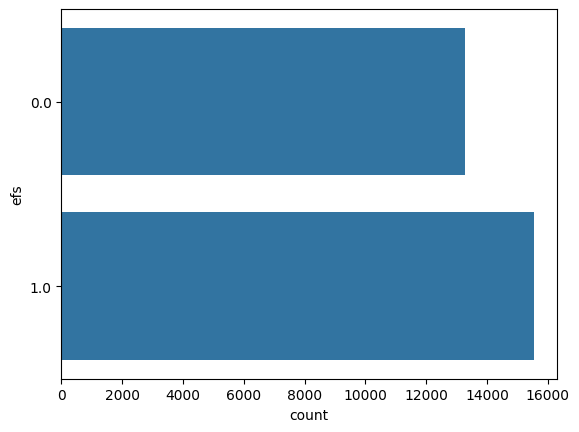

C:\Users\tkvkh\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\_memmapping_reducer.py:598: UserWarning: Failed to delete temporary folder: C:\Users\tkvkh\AppData\Local\Temp\joblib_memmapping_folder_17108_7a89c4fbb95a4e508e69eee4d67976b5_3574a186dbd0470b9fa829b453b70b39
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\tkvkh\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\_memmapping_reducer.py:598: UserWarning: Failed to delete temporary folder: C:\Users\tkvkh\AppData\Local\Temp\joblib_memmapping_folder_17108_c9717483e525427b91caffbe3fd3285a_369ee214bf6c4b729740d82033939b87
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\tkvkh\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\_memmapping_reducer.py:598: UserWarning: Failed to delete temporary folder: C:\Users\tkvkh\AppData\Local\Temp\joblib_memmapping_folder_17108_7a89c4fbb95a4e508e69eee4d67976b5_d9b27a7f09e94588a837353595cac00b
  warnings.warn("Failed to 

In [53]:
sns.countplot(data=train, y="efs")